In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from astropy import constants as const

# Define constants

In [2]:
pi = np.pi
BIGG = const.G.value
MSUN = const.M_sun.value
AU = const.au.value

NMINSTEPS = 10000
NWALKERS = 25
NSAMPLES = 10000
VSUN = np.array([10.0, 11.0, 7.0])

S1 = 26.
S2 = 18.
S3 = 15.
PHI = 2.
VD = np.radians(12.)

THETA = np.radians(122.932)
ANGP = np.radians(192.859508)
DNGP = np.radians(27.128336)

OUMUAMUA_COORDS = [np.radians(279.804-360.), np.radians(33.997)]        

In [3]:
T1 = [[np.cos(THETA), np.sin(THETA), 0], [np.sin(THETA), -np.cos(THETA), 0], [0, 0, 1]]    
T2 = [[-np.sin(DNGP), 0, np.cos(DNGP)], [0, 1, 0], [np.cos(DNGP), 0, np.sin(DNGP)]]        
T3 = [[np.cos(ANGP), np.sin(ANGP), 0], [-np.sin(ANGP), np.cos(ANGP), 0], [0, 0, 1]]

T = np.matmul(np.matmul(T1, T2), T3) 

# Draw samples from MCMC

In [4]:
def schwarzschild_dist(v, s1, s2, s3):
    return np.exp(-(v[0]**2/(2*s1**2) + v[1]**2/(2*s2**2) + v[2]**2/(2*s3**2)))/(s1*s2*s3*(2*pi)**1.5)

def ln_schwarzschild(v, s1, s2, s3):
    return np.log(schwarzschild_dist(v, s1, s2, s3))

def focusing_prob(v, phi):
    return 1. + (42./(np.linalg.norm(v-VSUN) + phi))**2

def ln_focusing(v, phi):
    return np.log(focusing_prob(v, phi))

def ln_pdf(v, s1, s2, s3, phi):
    return ln_focusing(v, phi) + ln_schwarzschild(v, s1, s2, s3)

In [5]:
def get_f(x, logpdf, *args):
    if len(x) == 1:
        return [logpdf(x[0], *args)]
    else:
        f0 = logpdf(x[0], *args)
        return np.concatenate(([f0], get_f(x[1:], logpdf, *args)))

def mcmc_vectorized(x0, nminsteps=1, step=1., logpdf=None, args=None, nconv=1000, convergence_func=None, conv_args=None):
    x = x0
    nsteps = 0
    converged = False
    fnow = np.array(get_f(x, logpdf, *args))

    chain = [x0]
    while not converged or nsteps < nminsteps:
        xtry = x + step*np.random.uniform(-1, 1, size=x.shape)
        ftry = np.array(get_f(xtry, logpdf, *args))

        accept = np.array(ftry > fnow)
        x[accept] = xtry[accept]
        fnow[accept] = ftry[accept]
      
        u = np.random.uniform(size=x.shape[0])
        log_accept = np.array(np.log(u) < ftry - fnow)
        x[(log_accept)*(~accept)] = xtry[(log_accept)*(~accept)]
        fnow[(log_accept)*(~accept)] = ftry[(log_accept)*(~accept)]
        chain.append(np.copy(x))
        nsteps = nsteps + 1
        
        if nsteps % nconv == 0:
            if convergence_func is None:
                converged = True
            else:
                converged = convergence_func(chain, conv_args)
    
    return np.array(chain)

def gr_indicator(chain, gr_threshold=1.01):
    
    if len(np.shape(chain)) == 3:
        nsteps, nwalkers, ndim = np.shape(chain)
    elif len(np.shape(chain)) == 2:
        nsteps, nwalkers = np.shape(chain)
    else:
        nsteps = np.shape(chain)
        nwalkers = 1
    
    sj2 = np.sum((chain-np.mean(chain, axis=0))**2, axis=0)/(nsteps-1)
    sw2 = np.sum(sj2, axis=0)/nwalkers

    xjbar = np.sum(chain, axis=0)/nsteps
    xbar = np.sum(xjbar, axis=0)/nwalkers

    sv2 = (nsteps-1)*sw2/nsteps + np.sum((xjbar-xbar)**2)/(nwalkers-1)

    R_GR = sv2/sw2
    converged = np.all(R_GR < gr_threshold)
    
    return converged

In [6]:
x = stats.truncnorm.rvs(0., 25., scale=25., size=(NWALKERS, 3))
vel = mcmc_vectorized(x, nminsteps=NMINSTEPS, logpdf=ln_pdf, args=(S1, S2, S3, PHI), \
                      convergence_func=gr_indicator, conv_args=(1.5))

In [7]:
NVEL = len(vel)*NWALKERS
vel = vel.reshape((NVEL, 3))
print('%d candidates generated from MCMC' %NVEL)

800025 candidates generated from MCMC


In [8]:
sample_indices = np.random.choice(np.arange(NVEL), size=NSAMPLES)
vel = vel[sample_indices]

# Change frame from LSR to galactic/heliocentric

In [9]:
vel = vel - np.tile(VSUN, (NSAMPLES, 1))

In [10]:
def get_ra_dec(R):
    R = np.matmul(np.linalg.inv(T), R)
    mag = np.linalg.norm(R)
    dec = np.arcsin(R[2]/mag)
    if R[1]/mag > 0:
        ra = np.arccos(R[0]/(mag*np.cos(dec)))
    else:
        ra = 2*pi-np.arccos(R[0]/(mag*np.cos(dec)))
    if ra >= pi:
        ra = ra - 2*pi
    return np.asarray([ra, dec])

pos = np.zeros((NSAMPLES, 2))
for i, v in enumerate(vel):
    v = np.array([v[0]*np.cos(VD) + v[1]*np.sin(VD), -v[0]*np.sin(VD) + v[1]*np.cos(VD), v[2]])
    pos[i] = get_ra_dec(-v)                      

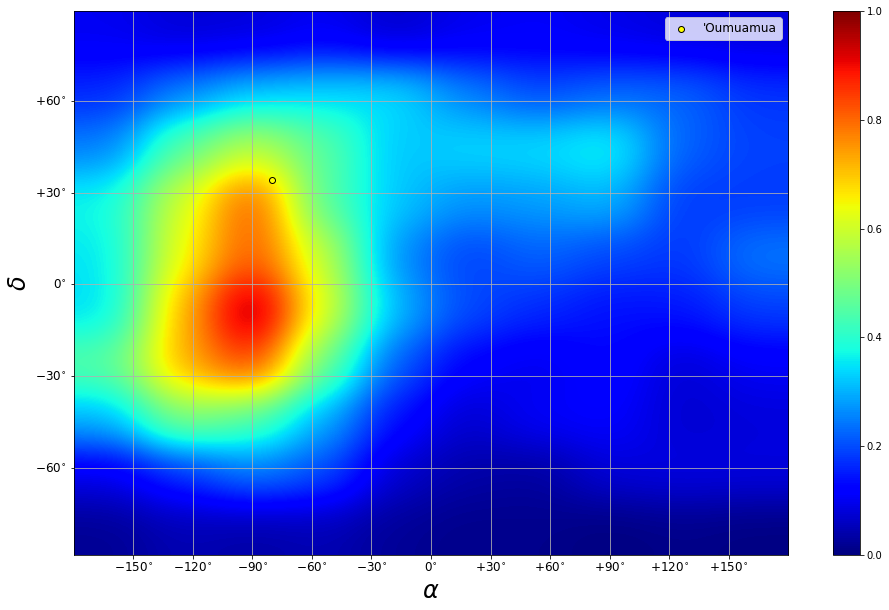

In [11]:
plt.figure(figsize=(16, 10))

H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=10)
plt.imshow(H.transpose()[::-1], extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='gaussian', \
           aspect='auto', cmap='jet')

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'))

plt.show()

# Draw b and $\psi$

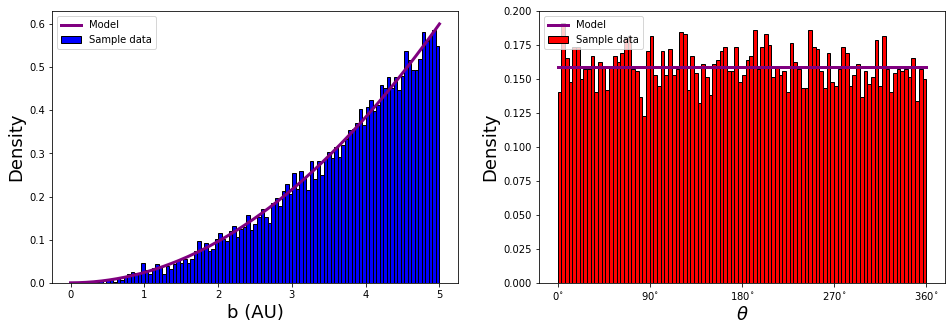

In [12]:
A = 0.                                                     
B = 5.

def sample_b_dist(N=NSAMPLES, a=0, b=5):                  
    P = np.random.uniform(size=N)
    return (P*(b**3-a**3) + a**3)**(1/3)

b = sample_b_dist(a=A, b=B)
psi = np.random.uniform(low=0, high=2*pi, size=NSAMPLES)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax1 = axes[0]
ax1.hist(b, color='blue', edgecolor='k', bins=100, density=True, label='Sample data')
x = np.linspace(A, B, 1000)
ax1.plot(x, 3*x**2/(B**3-A**3), c='purple', lw=3, label='Model')                         
ax1.set_xlabel('b (AU)', fontsize=18)
ax1.set_ylabel('Density', fontsize=18)
ax1.legend(loc='upper left', fontsize=10)

ax2 = axes[1]
ax2.hist(psi, color='red', edgecolor='k', bins=100, density=True, label='Sample data')
ax2.plot(np.linspace(0, 2*pi, 1000), np.repeat([1/(2*pi)], 1000), c='purple', lw=3, label='Model')  
ax2.set_xlabel(r'$\theta$', fontsize=18)
ax2.set_xticks([0, pi/2, pi, 3*pi/2, 2*pi])
ax2.set_xticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$', r'$270^{\circ}$', r'$360^{\circ}$'])
ax2.set_ylabel('Density', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_ylim(0, 0.2)

plt.show()

In [13]:
RSKY = 5.                                                                        

R = np.zeros((NSAMPLES, 3))
b_vec = np.zeros_like(R)
R_sky = np.zeros_like(R)

for i, v in enumerate(vel):
    R_sky[i] = -np.sqrt(RSKY**2-b[i]**2)*v/np.linalg.norm(v)
    phi = np.arctan(-(np.cos(psi[i])*v[0] + np.sin(psi[i])*v[1])/v[2])
    b_vec[i] = np.array([b[i]*np.cos(phi)*np.cos(psi[i]), b[i]*np.cos(phi)*np.sin(psi[i]), \
                         b[i]*np.sin(phi)])
    R[i] = R_sky[i] + b_vec[i]

# REBOUND simulations

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).


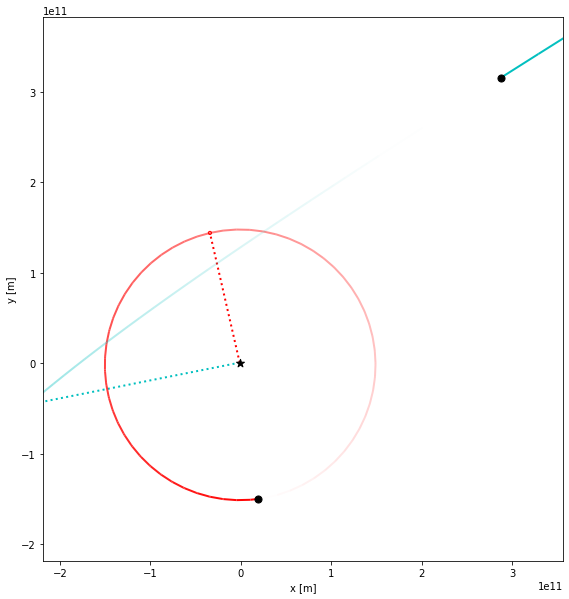

In [14]:
import rebound

NTIMES = 100
INTEGRATION_TIME = 3.*365.*24.*60.*60.  

sim = rebound.Simulation()
sim.units = ('s', 'm', 'kg')
sim.add('Sun')
sim.add('Earth')
sim.save('ss.bin')

def dist_closest_encounter(R, v):
    sim = rebound.Simulation('ss.bin')
    sim.add(x=R[0]*AU, y=R[1]*AU, z=R[2]*AU, vx=v[0]*1000., vy=v[1]*1000., vz=v[2]*1000.)
    
    ps = sim.particles
    times = np.linspace(0, INTEGRATION_TIME, NTIMES)
    distances = np.zeros_like(times)
    
    for i, t in enumerate(times):
        sim.integrate(t)
        dp = ps[2] - ps[1]
        distances[i] = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)

    sim.remove(ps[-1])
    return np.min(distances)/AU

def plot_orbit(R, v):
    sim = rebound.Simulation('ss.bin')
    sim.add(x=R[0]*AU, y=R[1]*AU, z=R[2]*AU, vx=v[0]*1000., vy=v[1]*1000., vz=v[2]*1000.)
    
    rebound.OrbitPlot(sim, color=True, periastron=True, lw=2, figsize=(16, 10), \
                      unitlabel='[m]')
    
plot_orbit(R[0], vel[0])

In [15]:
'''
min_distances = np.zeros(NSAMPLES)
for i, d in enumerate(min_distances):
    min_distances[i] = dist_closest_encounter(-vel[i], vel[i])
    
frac_close_encounter = len(min_distances[min_distances <= 0.1])/len(min_distances)
print('# Close encounters: %.3f %%' %(frac_close_encounter*100))
'''

"\nmin_distances = np.zeros(NSAMPLES)\nfor i, d in enumerate(min_distances):\n    min_distances[i] = dist_closest_encounter(-vel[i], vel[i])\n    \nfrac_close_encounter = len(min_distances[min_distances <= 0.1])/len(min_distances)\nprint('# Close encounters: %.3f %%' %(frac_close_encounter*100))\n"